<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cats-Vs-Dogs/Resized%20cats%20vs%20dogs/CvD_15_15_Gabor_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:
!unzip /content/drive/My\ Drive/Gabor\ Dataset/all-cats-vs-dogs.zip -d cats-vs-dogs

In [4]:
ITERATION = 10
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32

In [5]:
filenames = os.listdir("cats-vs-dogs/all/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

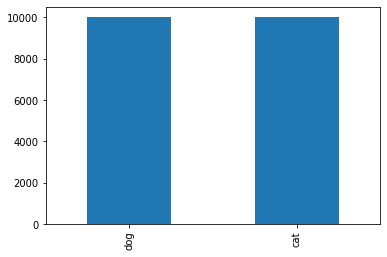

In [7]:
train_df['category'].value_counts().plot.bar()

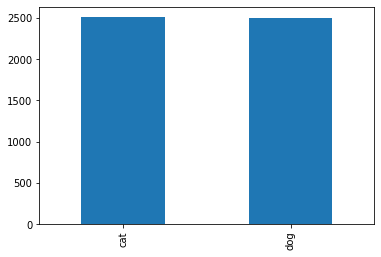

In [8]:
validate_df['category'].value_counts().plot.bar()

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


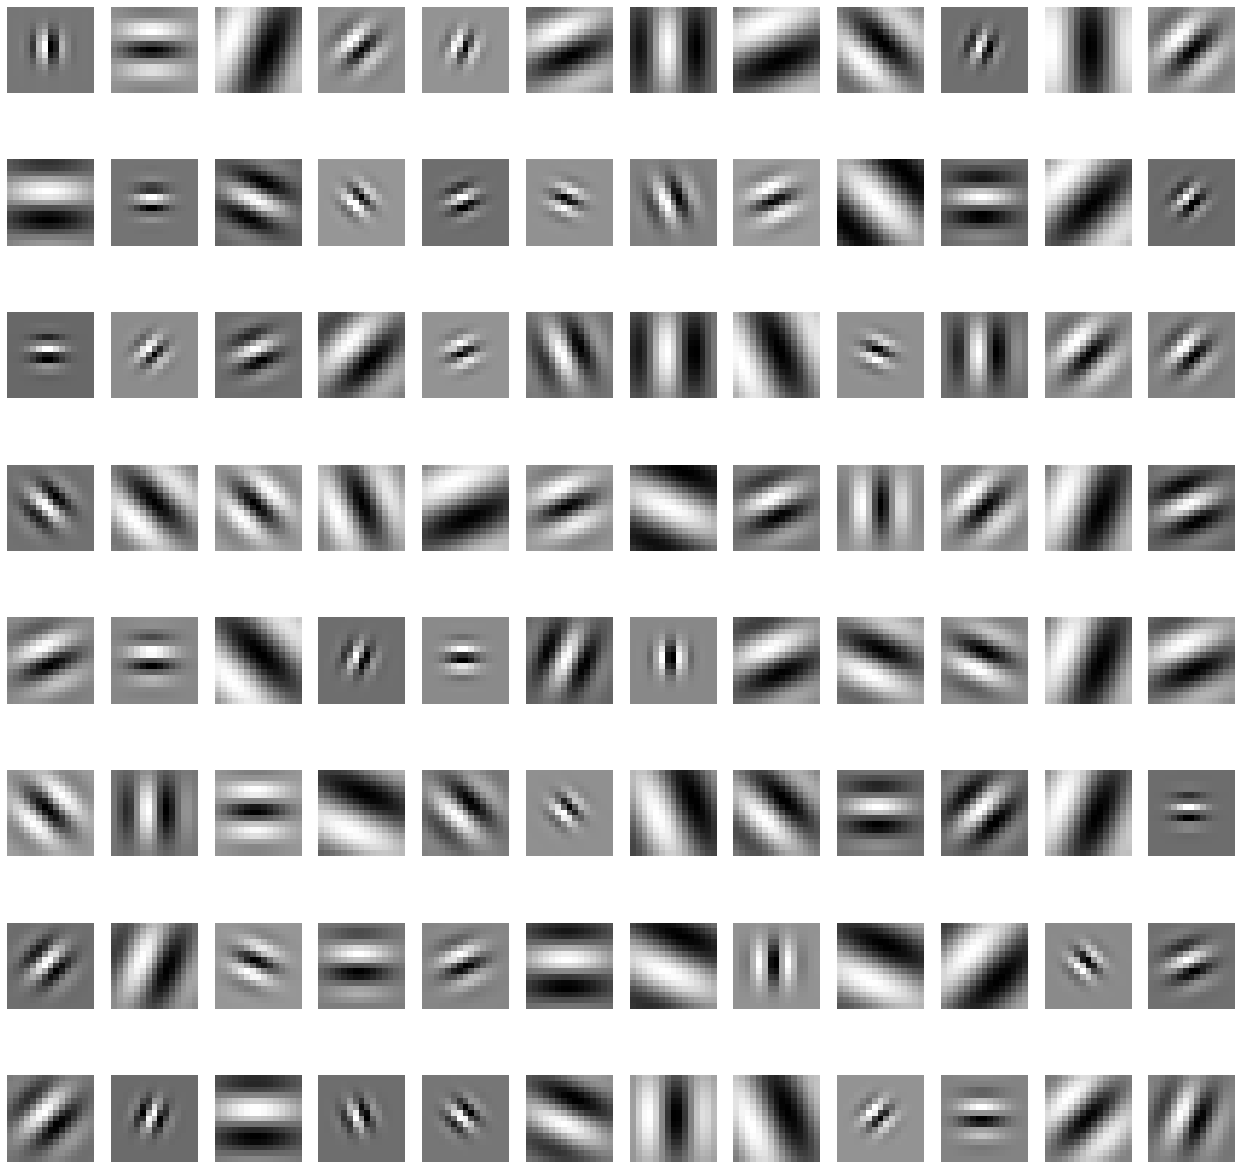

In [11]:
import math

def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (math.pi/2)*(math.sqrt(2)**(-np.random.randint(0,5, (outchannels, inchannels))))
    thetas = (math.pi/8)*np.random.randint(0,8, (outchannels, inchannels))
    sigmas = math.pi/(freqs)
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
#             g = g / (2 * math.pi * (sigma ** 2))
#             g = gabor_kernel(frequency=freq, bandwidth=sigma, theta=theta, offset=psi, n_stds=0).real
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, NUM_RECEPTIVE_FILTERS, GABOR_SIZE)

fig = plt.subplots(8, len(filterbank)//8, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [18]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 242, 242, 32)      21632     
_________________________________________________________________
batch_normalization_4 (Batch (None, 242, 242, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

[[array([[[[-4.78913944e-06, -4.53458540e-02,  3.38877216e-02, ...,
          -2.27836054e-02, -2.10521162e-01,  1.77864403e-01],
         [-4.53458540e-02,  3.38877216e-02, -1.84090075e-03, ...,
          -2.10521162e-01,  1.77864403e-01, -2.47064736e-06],
         [ 3.38877216e-02, -1.84090075e-03,  4.32117531e-06, ...,
           1.77864403e-01, -2.47064736e-06,  6.64239144e-03]],

        [[ 2.28283488e-06, -6.99075311e-02,  2.30822980e-01, ...,
           1.91465225e-02, -2.50961185e-01,  1.93661719e-03],
         [-6.99075311e-02,  2.30822980e-01, -8.18309549e-04, ...,
          -2.50961185e-01,  1.93661719e-03, -2.50801240e-05],
         [ 2.30822980e-01, -8.18309549e-04, -1.12965408e-05, ...,
           1.93661719e-03, -2.50801240e-05, -4.64035943e-02]],

        [[ 1.12502399e-04, -1.00311875e-01,  4.26238775e-01, ...,
           8.95624235e-02, -1.84794590e-01, -2.12994739e-01],
         [-1.00311875e-01,  4.26238775e-01,  6.76293578e-03, ...,
          -1.84794590e-01, -2.12

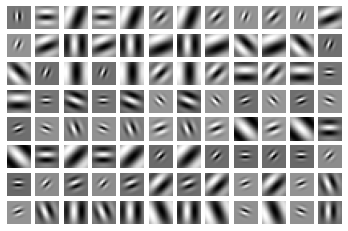

In [19]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape
gabor_filters = W
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index+channel_index]

classifier.get_layer(name=cnnl1).set_weights([gabor_filters, classifier.get_layer(name=cnnl1).get_weights()[1]])

filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig('cvd-{}-initial-gabor-random-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')

import copy
untrained_layers = []
for layer in classifier.layers:
  untrained_layers.append(copy.deepcopy(layer.get_weights()))
print(untrained_layers)

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = RMSprop(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/10
625/625 [==============================] - 61s 96ms/step - loss: 0.9493 - accuracy: 0.6048 - val_loss: 0.5794 - val_accuracy: 0.7190
Epoch 2/10
625/625 [==============================] - 60s 95ms/step - loss: 0.5377 - accuracy: 0.7394 - val_loss: 0.7343 - val_accuracy: 0.7021
Epoch 3/10
625/625 [==============================] - 60s 95ms/step - loss: 0.4914 - accuracy: 0.7658 - val_loss: 0.5391 - val_accuracy: 0.7322
Epoch 4/10
625/625 [==============================] - 60s 95ms/step - loss: 0.4579 - accuracy: 0.7864 - val_loss: 0.5494 - val_accuracy: 0.7590
Epoch 5/10
625/625 [==============================] - 60s 95ms/step - loss: 0.4294 - accuracy: 0.8021 - val_loss: 0.4685 - val_accuracy: 0.7827
Epoch 6/10
625/625 [==============================] - 59s 94ms/step - loss: 0.4156 - accuracy: 0.8134 - val_loss: 0.4728 - val_accuracy: 0.7911
Epoch 7/10
625/625 [==============================] - 59s 94ms/step - loss: 0.3855 - accuracy: 0.8278 - val_loss: 0.5279 - val_accuracy:

In [21]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 2037.33960875
Finish time = 2632.911953998
Training time = 595.5723452480001


In [23]:
import pickle


trained_layers = []
for layer in classifier.layers:
  trained_layers.append(copy.deepcopy(layer.get_weights()))
print(trained_layers)
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers


with open('cvd-{}-history-gabor-random-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

[[array([[[[-1.19524233e-01, -6.57470450e-02,  3.53762433e-02, ...,
          -3.97647023e-02, -3.01398188e-01,  1.29350632e-01],
         [-1.00998811e-01,  8.53568390e-02, -4.63627242e-02, ...,
          -2.65000284e-01,  1.05809994e-01, -5.42883994e-03],
         [ 4.64255624e-02,  5.78015931e-02, -7.77780265e-02, ...,
           1.32051021e-01, -7.80304000e-02,  3.21767777e-02]],

        [[-1.04672268e-01, -8.85121301e-02,  2.40634844e-01, ...,
           1.16743287e-03, -3.36643875e-01, -4.80167344e-02],
         [-1.09834552e-01,  2.76170760e-01, -3.36375758e-02, ...,
          -3.09382498e-01, -6.94251880e-02, -4.71576815e-03],
         [ 2.48244613e-01,  5.43090738e-02, -6.30485341e-02, ...,
          -5.32383174e-02, -6.76832497e-02, -1.78935546e-02]],

        [[-8.75739530e-02, -1.09711342e-01,  4.45651084e-01, ...,
           8.06450397e-02, -2.80745029e-01, -2.73743272e-01],
         [-1.38197348e-01,  4.90231901e-01, -1.04920799e-02, ...,
          -2.32396677e-01, -2.79

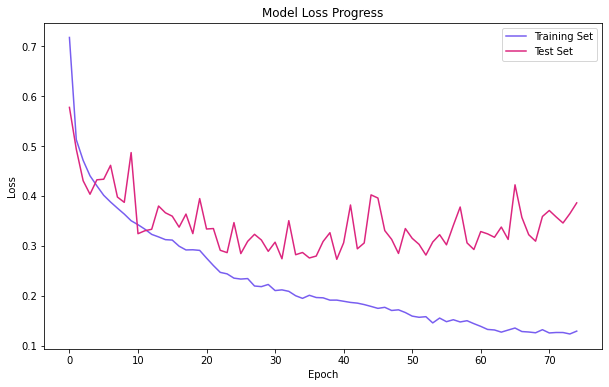

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cvd-{}-loss-gabor-random-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

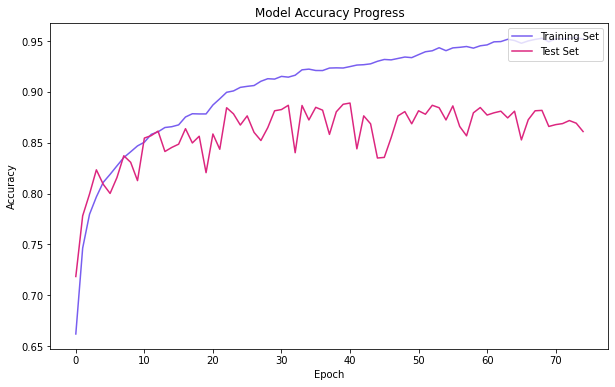

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cvd-{}-accuracy-gabor-random-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

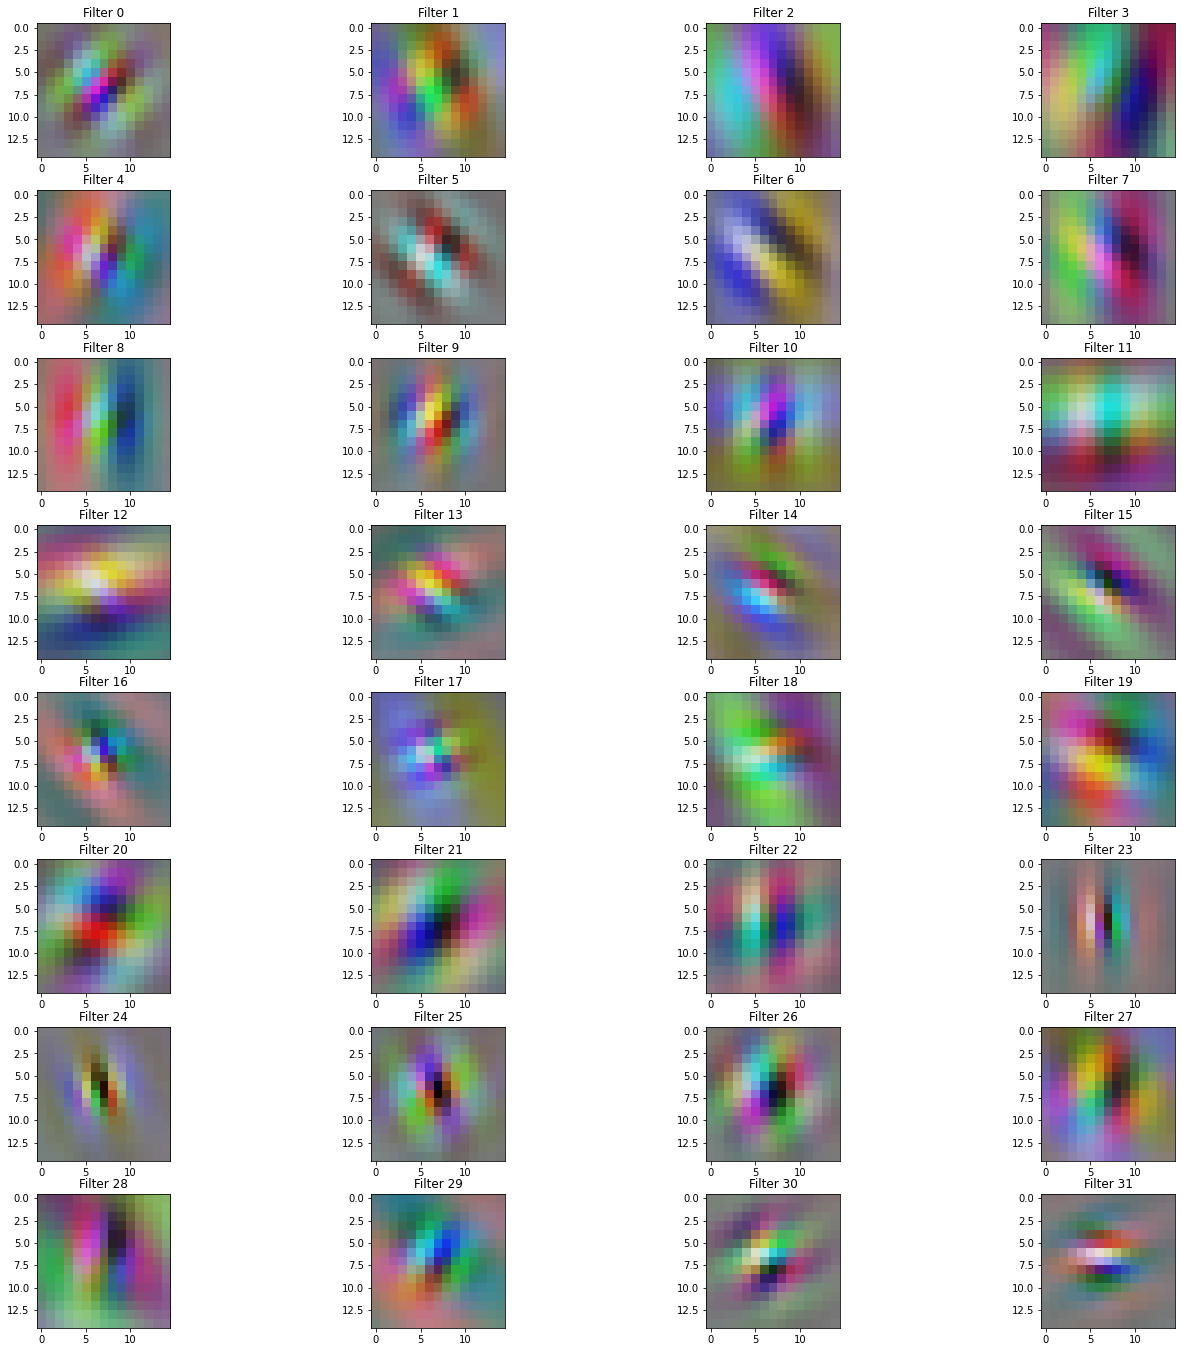

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cvd-{}-filters-gabor-random-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-1.134521 1.2723486


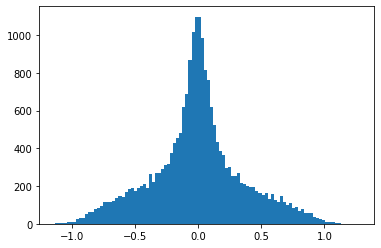

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

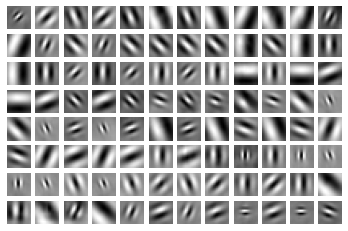

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("cvd-{}-channelwise-gabor-random-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)